In [153]:
!pip install imbalanced-learn

In [154]:
#general purpose libraries
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipe

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [155]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [156]:
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [157]:
#importing colab libraries
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/SentimentBasedProductRecommendation')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. EDA

In [158]:
# Reading the input from folder
master_df = pd.read_csv('sample30.csv')
df_reviews=master_df.copy()
df_reviews.sample(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
12862,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2014-12-17T00:00:00.000Z,False,True,5,Good product. It is effect for what I need it for. This review was collected as part of a promotion.,Wipes review,NaN,NaN,bill25,Positive
24303,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2014-12-30T00:00:00.000Z,NaN,True,4,Not a bad movie...some things were questionable about the movie but still viewable.,A good movie,NaN,NaN,madman68,Negative
7590,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2015-01-14T00:00:00.000Z,False,True,4,Easy to use and convenient. Disinfects without the smell of bleach. Everything is lemon fresh and clean. Great for cleaning up accidental pet stains. This review was collected as part of a promotion.,Fresh and Clean,NaN,NaN,miamay,Positive
17346,AVpfazX31cnluZ0-kbdl,Just For Men,"Personal Care,Hair Care,Hair Color And Bleaching,Hair Color,Beauty & Personal Care,Hair Coloring Products,Color Correctors,Beauty,Hair Treatments",Combe Incorporated,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",2013-07-11T00:00:00.000Z,False,NaN,3,"The products started working well at the beginning (4 months ago), but it now leaves a lot of gray. I have to apply at least every other week.",Good product but it doesn't get rid of enough gray,NaN,NaN,middleaged2,Negative
1022,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass Cleaners,Health & Household,Household Supplies,Household Cleaning,Featured Brands,Home And Storage & Org,Thanksgathering,All-purpose Cleaners,Target Restock,Food & Grocery,Glass & Window",Windex,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),2014-02-27T00:00:00.000Z,True,True,5,I like buying the economy size...keeps less trash out of landfills. Windex works very well.,Great product,NaN,NaN,cposton,Positive


EDA- Data cleaning

In [159]:
df_reviews.shape

(30000, 15)

In [160]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [161]:
#Null value analysis
df_reviews.isnull().sum()

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,14068
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


In [162]:
df_reviews['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [163]:
# Define function to map ratings to sentiment
def infer_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating <= 2:
        return 'Negative'
    else:
        return 'neutral'  # Optional: Can be ignored if working with only pos/neg

# Fill missing user_sentiment using reviews_rating
df_reviews['user_sentiment'].fillna(df_reviews['reviews_rating'].map(infer_sentiment), inplace=True)

In [164]:
# Verify missing value in user-sentiment column

df_reviews['user_sentiment'].isnull().sum()

np.int64(0)

<Axes: xlabel='user_sentiment', ylabel='count'>

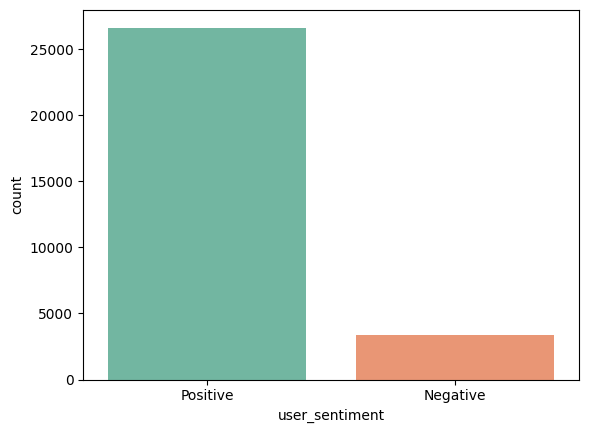

In [165]:
#Visualize using count plot
sns.countplot(x='user_sentiment', data= df_reviews, palette="Set2")

In [166]:
# Analyze the rating column

df_reviews["reviews_rating"].value_counts()

,count
reviews_rating,
5,20831
4,6020
1,1384
3,1345
2,420


<Axes: xlabel='reviews_rating'>

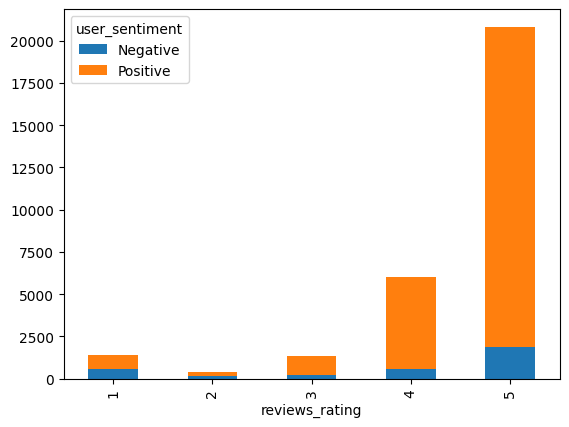

In [167]:
# Check sentiment distribution across ratings

df_reviews.groupby(['reviews_rating', 'user_sentiment']).size().unstack().plot(kind='bar', stacked=True)

In [168]:
# Identify mismatched cases: High ratings with negative sentiment
high_rating_negative = df_reviews[(df_reviews['reviews_rating'] >= 4) & (df_reviews['user_sentiment'] == 'Negative')]

# Identify mismatched cases: Low ratings with positive sentiment
low_rating_positive = df_reviews[(df_reviews['reviews_rating'] <= 2) & (df_reviews['user_sentiment'] == 'Positive')]


In [169]:
# Display sample cases
print("High Rating (4-5) with Negative Sentiment:")
high_rating_negative[['reviews_rating', 'reviews_text', 'user_sentiment']].head(10)

High Rating (4-5) with Negative Sentiment:


,reviews_rating,reviews_text,user_sentiment
92,4,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,Negative
96,4,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,Negative
100,4,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,Negative
106,4,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",Negative
117,4,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",Negative
121,4,"I hate to be picky, but who was responsible for the design of this product Push down on top of the package to dispense product from center of package... Even the directions are awkward! The cream is yummy, the design I really hate!",Negative
144,4,Regenerist provides a deep hydration of the skin. I find my skin is smoother after use. This review was collected as part of a promotion.,Negative
153,4,I have used the product since I was 16 I have tried others just not the same.my mom used it how I learned about it,Negative
160,4,Works well with skin contour hides blemishes and wrinkles,Negative
166,4,This product is really helpful for dry rough skin and I use their product everyday,Negative


In [170]:
print("\nLow Rating (1-2) with Positive Sentiment:")
low_rating_positive[['reviews_rating','reviews_title','reviews_text', 'user_sentiment']].head(10)


Low Rating (1-2) with Positive Sentiment:


,reviews_rating,reviews_title,reviews_text,user_sentiment
9,1,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,Positive
11,1,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,Positive
14,1,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,Positive
54,1,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",Positive
56,1,Please bring back the old formula,"I am so disappointed! I have used this product for years because of it's soft smell and great results. The new formula feels greasy, smells awful and I don't feel like my skin looks as toned and wrinkle free anymore. This was a five star product for so many years...why change it Please bring bac...",Positive
58,1,Please Bring Back Old Formula,"It took me so long to find a moisturizer that worked well for me and I loved this product. However, this new formula has a smell that is too strong for me and feels very greasy once applied. Unfortunately I will no longer be purchasing this product and will have to search again for another moist...",Positive
60,1,The product smells ok,Olay don't work for me I have overly dry skin. I haven't found anything to work on my skin. So I'm hoping to be able to find something that will work. But I'm affrid I won't be able to find anything to help my skin not be so dry. It gets so bad the I dig at my legs all the time.,Positive
64,2,Not a good base for makeup!,"While this product probably does leave faces feeling nourished, I would not recommend using it as a daily moisturizer under makeup. It left my face full of crumbles as soon as I brushed on my makeup. Would probably be better as a night cream.",Positive
66,2,Nice,GreatGreatmefeels great smells great succulent took away dry skin silky smooth enriching,Positive
688,1,Doesn't clean windows,"Leaves windows with streaks, although it does seem to work OK on other surfaces.",Positive


**Observations Based on the Output**
<TBD>

1.   List item
2.   List item

In [171]:
def correct_sentiment(row):
    if row['reviews_rating'] >= 4 and row['user_sentiment'].lower() == 'negative':
        return 'Positive'  # Reclassify as positive
    elif row['reviews_rating'] <= 2 and row['user_sentiment'].lower() == 'positive':
        return 'Negative'  # Reclassify as negative
    else:
        return row['user_sentiment']  # Keep as is

# Apply corrections
df_reviews['user_sentiment'] = df_reviews.apply(correct_sentiment, axis=1)

In [172]:
# Analyze the rating column
df_reviews["reviews_rating"].value_counts()

,count
reviews_rating,
5,20831
4,6020
1,1384
3,1345
2,420


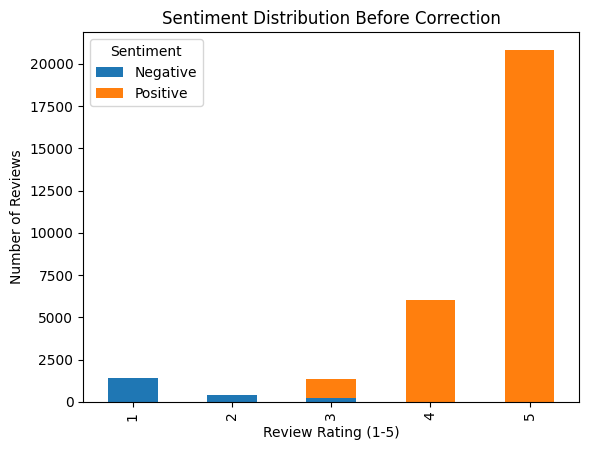

In [173]:
# Plot sentiment distribution before correction

df_reviews.groupby(['reviews_rating', 'user_sentiment']).size().unstack().plot(kind='bar', stacked=True)

plt.title("Sentiment Distribution Before Correction")
plt.xlabel("Review Rating (1-5)")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.show()

**Visual Analysis of data after correction**
<TBD>


1.   List item
2.   List item


In [174]:
df_reviews["brand"].value_counts()

,count
brand,
Clorox,10585
Warner Home Video,3325
Disney,1200
L'oreal Paris,1186
FOX,887
...,...
Pacific Natural Foods,1
LDR,1
National Mfg.,1


<Axes: xlabel='brand'>

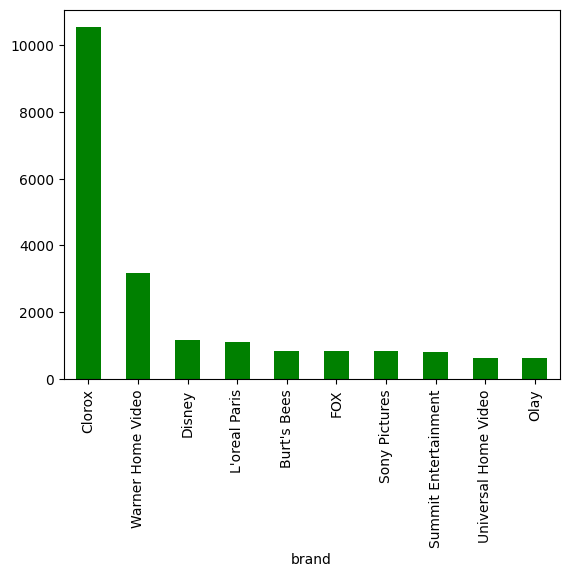

In [175]:
df_reviews[(df_reviews['user_sentiment'] == 'Positive')].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='g')

<Axes: xlabel='brand'>

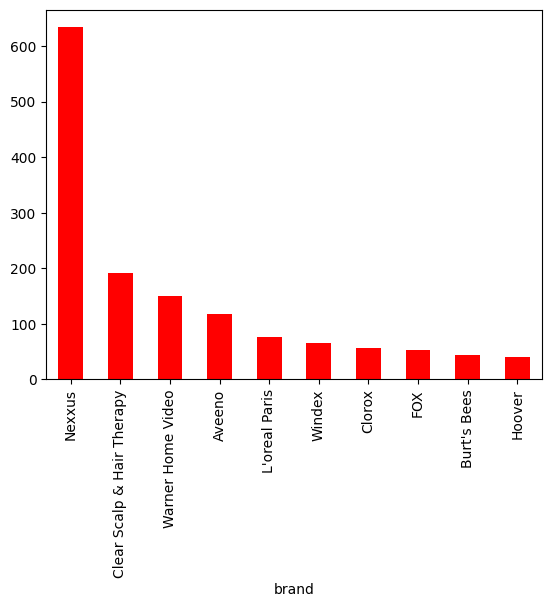

In [176]:
df_reviews[(df_reviews['user_sentiment'] == 'Negative')].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='r')

**Preprocessing & Feature Engineering**

In [177]:
# Handle missing values before combining title and text

df_reviews['full_review'] = df_reviews['reviews_title'].fillna('') + " " + df_reviews['reviews_text'].fillna('')

In [178]:
df_reviews[["full_review", "user_sentiment"]].sample(10)

,full_review,user_sentiment
9089,"Takes Care Of All Your Cleaning Needs From cleaning kitchen counters to doorknobs to bathrooms, this does it all. Leaves surfaces spotless, beautiful, and smelling great. I wouldn't recommend any other brand. For a quick, easy, sparkling clean Clorox wipes are the way to go. This review was coll...",Positive
7929,Best Thing Ever! This are great for those lazy cleaning days ) I use them everywhere both at home and at the office! I don't know what I'd do without them! This review was collected as part of a promotion.,Positive
14029,Great for cleaning My children love to play outside and come in and touch things with their dirty hands and Clorox products remove all stains This review was collected as part of a promotion.,Positive
5259,Love the Series All in all this is a very entertaining series of movies that SciFi and Fantasy buffs will (should) enjoy.,Positive
23493,Solid monster film Solid monster film when Godzilla is on screen but drops in quality because of some lackluster performances.,Positive
5205,excellent I love all the movies and having them all in one collection on blu ray is a wonderful thing.,Positive
9403,"Best Wipes Ever! We use these wipes in our cleaning business. Leaves the surfaces clean, disinfected, and smelling fabulous!! This review was collected as part of a promotion.",Positive
19336,quick cleanup These wipes are great for doing quick cleanups around the house. Disinfects and leaves a great scent behind,Positive
20086,"This product is helpful in keeping away the germs from my family I love the ease of Clorox wipes in keeping my house clean. I have two children under three, so there are a lot of messes. The wipe kills the germs and the pleasant scent isn't too strong like other wipes. Two thumbs up for Clorox F...",Positive
9940,love these wipes at school love the smell and how they clean so well in my classroom and they keep me from getting sick with all of the kids germs,Positive


In [179]:
# To download the stopwords from NLTK library
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

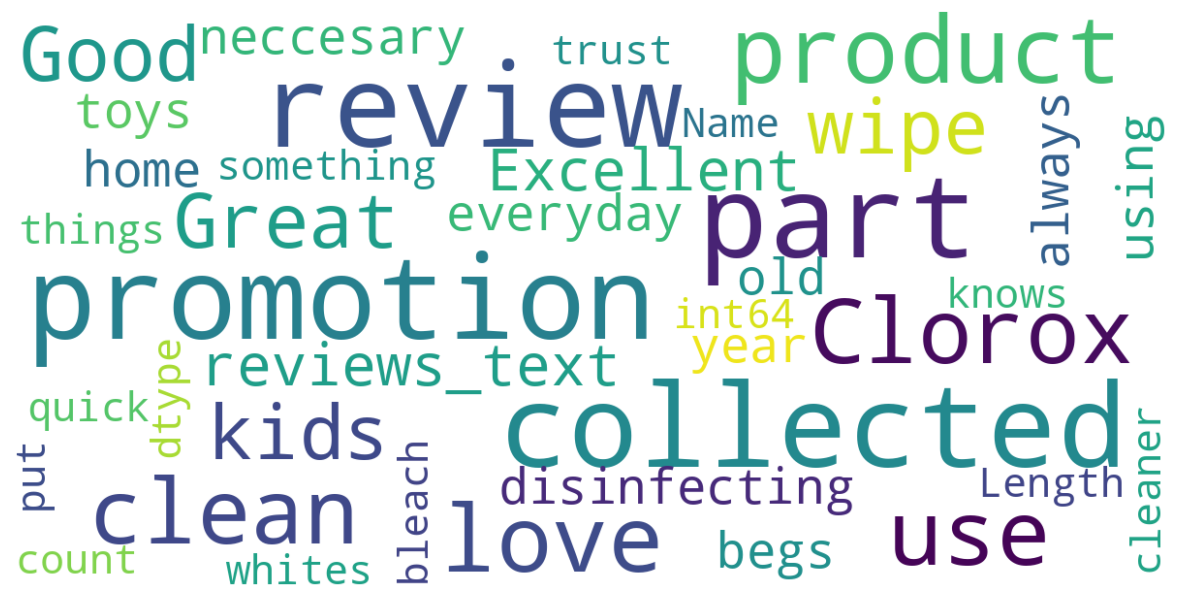

In [180]:
# To Check the most word occurence using word cloud
from wordcloud import WordCloud ,STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(df_reviews['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [181]:
#From the null values percentages, columns reviews_userCity and reviews_userProvince can be dropped
df_reviews = df_reviews.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)
df_reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,full_review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive,Good Good flavor. This review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,Negative,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation...."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [182]:
# Initialize NLP tools
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [183]:
pip install contractions

In [184]:
import string
from contractions import fix

def preprocess_text(text):
    """Preprocesses text: lowercasing, cleaning, tokenization, stopword removal, lemmatization."""

    text = fix(text)                                                  # Expand contractions (e.g., "can't" -> "cannot")
    text = text.lower()                                               # Convert to lowercase
    text = text.strip()                                               # Remove leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text)                                  # Normalize multiple spaces
    text = re.sub(r'\d+', '', text)                                   # Remove numbers
    text = re.sub(r'\[.*?\]', '', text)                               # Remove text within square brackets
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    tokens = word_tokenize(text)                                      # Tokenization
    tokens = [word for word in tokens if word not in stop_words]      # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]          # Lemmatization

    return ' '.join(tokens)

In [185]:
df_final = df_reviews[['id','name', 'full_review', 'reviews_rating','user_sentiment']]

In [186]:
# Download essential NLTK resources
nltk.download('punkt')  # For tokenization
nltk.download('punkt_tab')  # For tokenization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [187]:
# Apply preprocessing, cleaned & lemmatize review
df_final['cleaned_review'] = df_final['full_review'].apply(preprocess_text)

In [188]:
df_final.head()

,id,name,full_review,reviews_rating,user_sentiment,cleaned_review
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,5,Positive,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good Good flavor. This review was collected as part of a promotion.,5,Positive,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good Good flavor.,5,Positive,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation....",1,Negative,disappointed read review looking buying one couple lubricant ultimately disappointed even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked cap...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,1,Negative,irritation husband bought gel u gel caused irritation felt like burning skin would recommend gel


In [189]:
# Check if Review Length Differs by Sentiment Label
df_final['review_length'] = df_final['cleaned_review'].apply(len)

# check if positive and negative reviews have significantly different lengths.
df_final.groupby('user_sentiment')['review_length'].describe()

,count,mean,std,min,25%,50%,75%,max
user_sentiment,,,,,,,,
Negative,2024.0,195.19,154.20,6.0,92.75,160.0,250.0,2320.0
Positive,27976.0,122.19,111.32,3.0,65.00,94.0,142.0,3867.0


In [190]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [191]:
positive_reviews = df_final[(df_final['user_sentiment'] == 'Positive')]
getMostCommonWords(positive_reviews['cleaned_review'],10)

[('great', 14705),
 ('love', 11613),
 ('product', 11268),
 ('movie', 10533),
 ('review', 9189),
 ('part', 9024),
 ('promotion', 8626),
 ('collected', 8623),
 ('use', 8140),
 ('wipe', 8111)]

In [192]:
negative_reviews = df_final[(df_final['user_sentiment'] == 'Negative')]
getMostCommonWords(negative_reviews['cleaned_review'],10)

[('product', 1504),
 ('formula', 1406),
 ('new', 1188),
 ('hair', 1131),
 ('old', 989),
 ('gel', 864),
 ('back', 815),
 ('like', 696),
 ('used', 647),
 ('year', 591)]

In [193]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [194]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(positive_reviews['cleaned_review'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 1]]


,0,1
0,review collected,8622
1,collected promotion,8622
2,clorox wipe,2816
3,great product,1962
4,great movie,1756
5,easy use,1542
6,love clorox,1216
7,love product,1148
8,good movie,997
9,disinfecting wipe,848


--1 [[1 1 1 ... 1 1 2]]


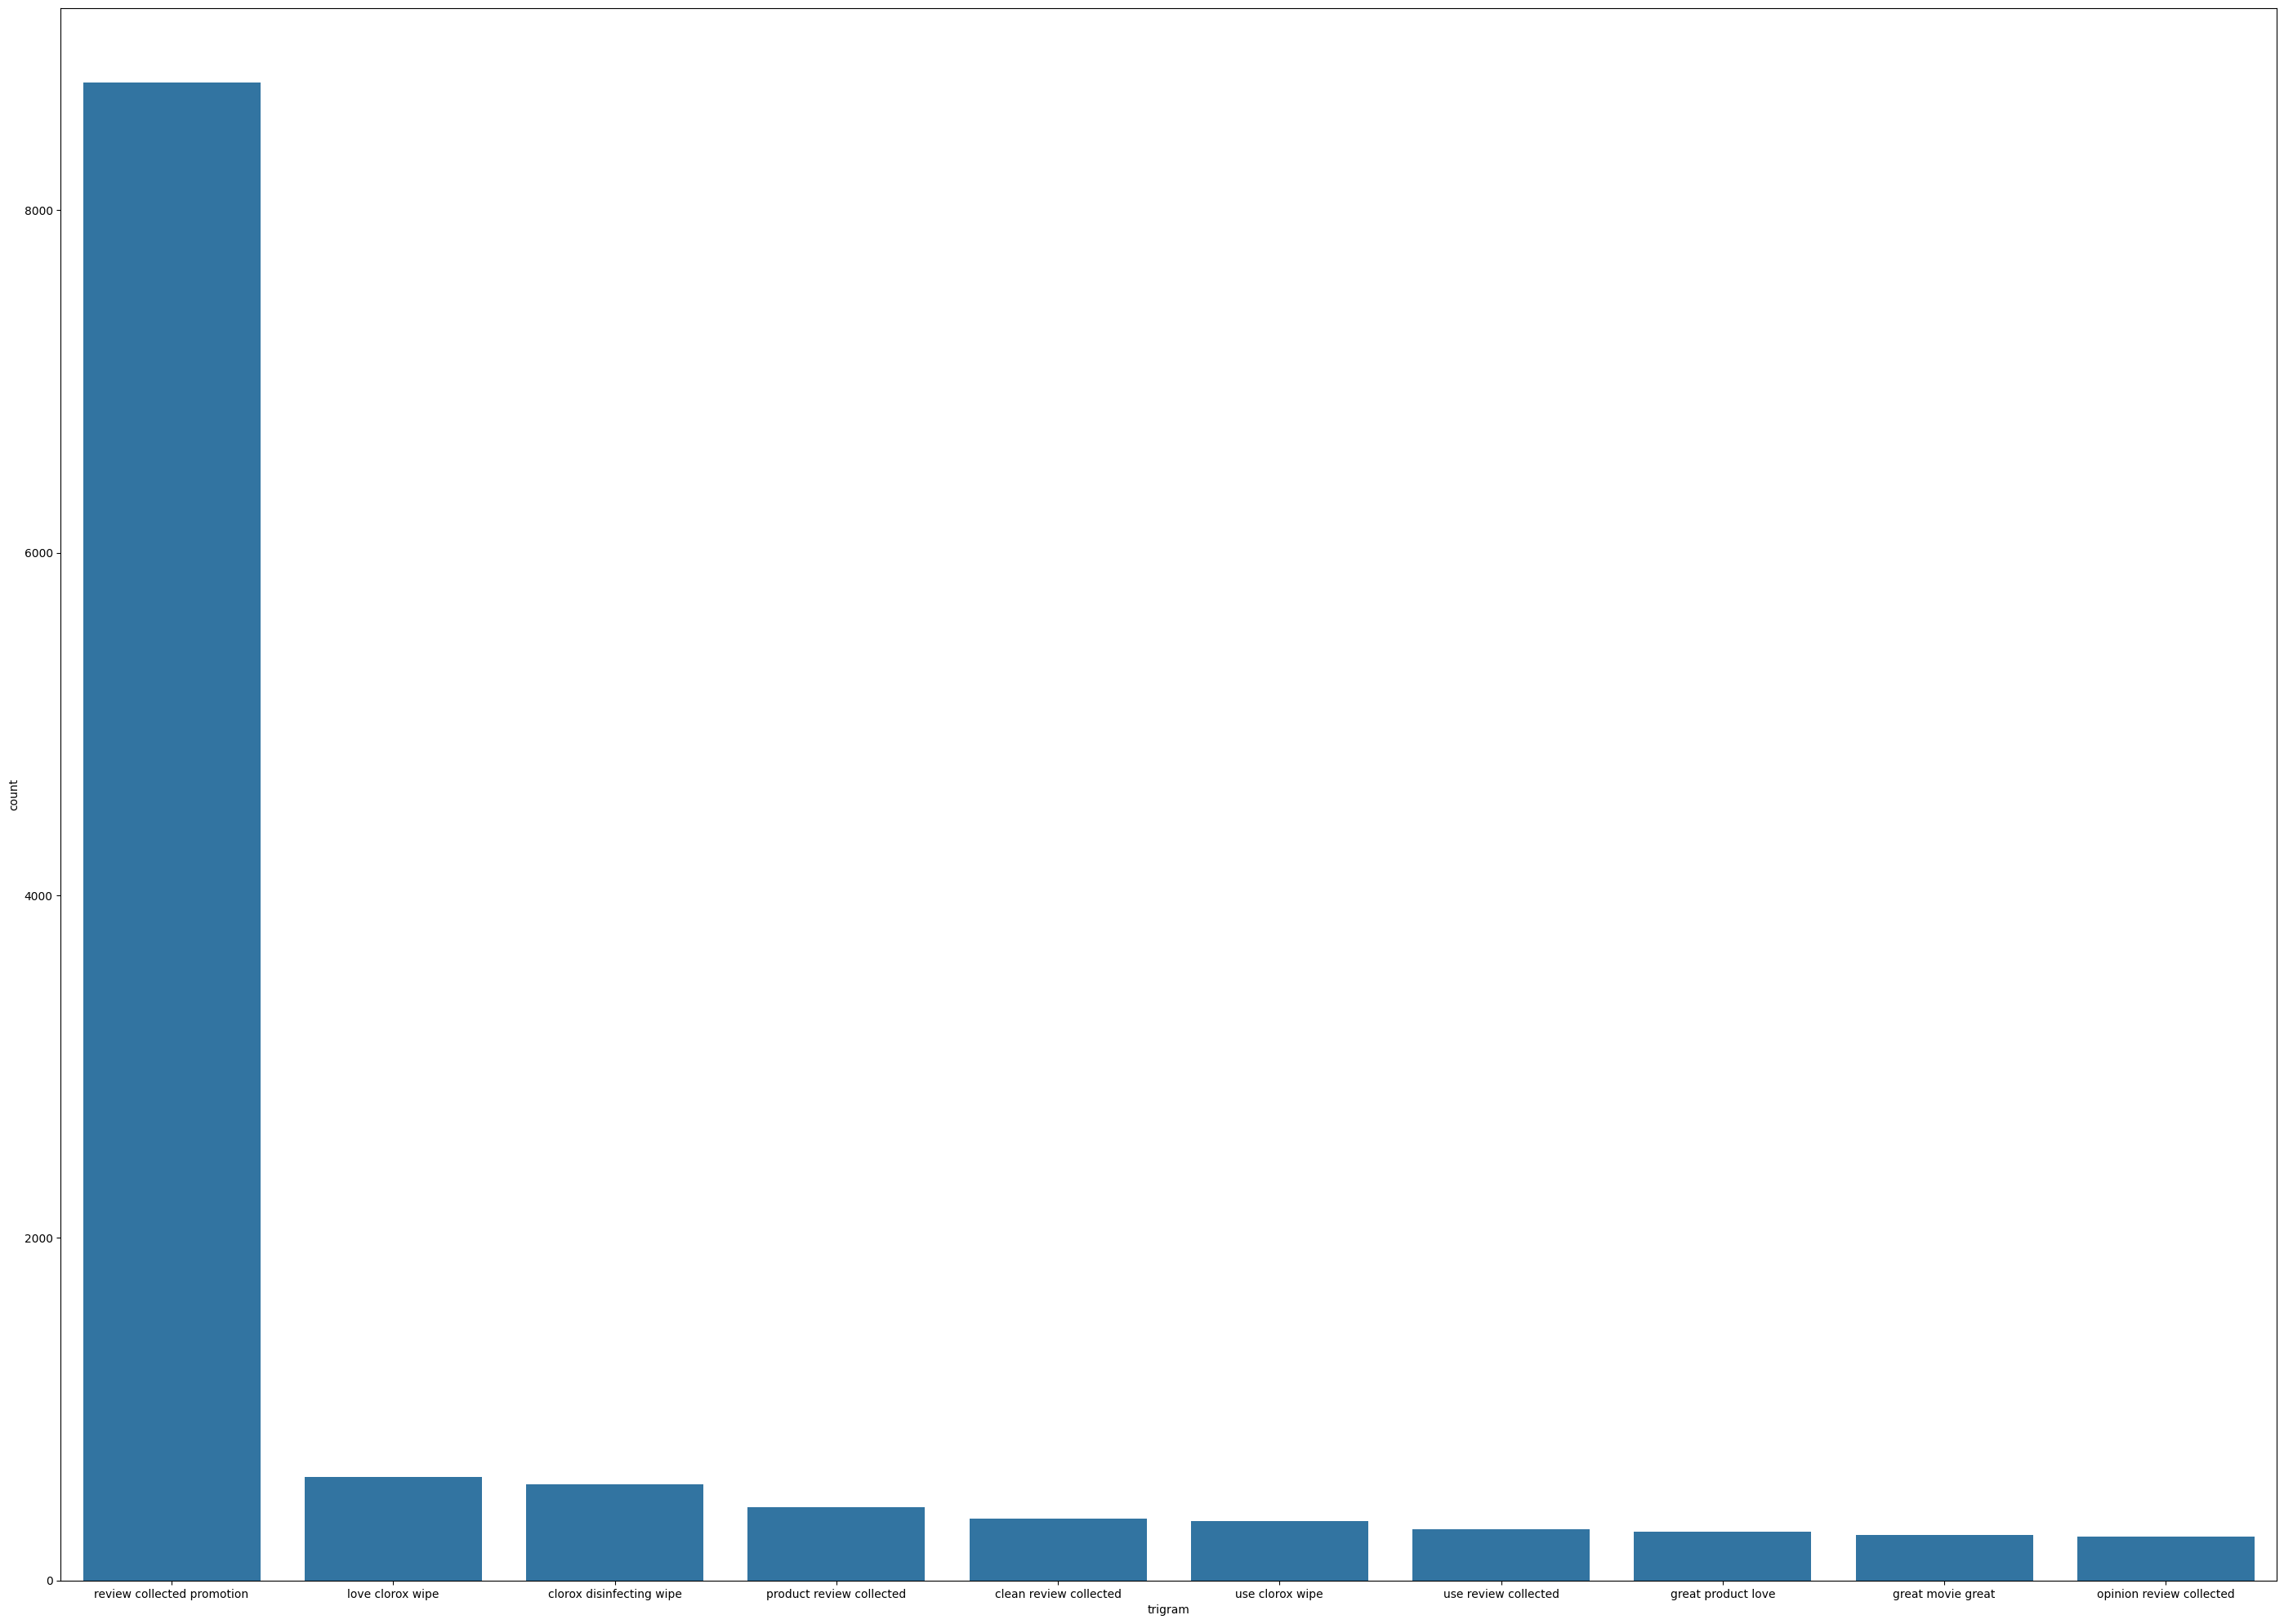

In [195]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean).
common_words = get_top_n_ngram(df_final.cleaned_review, 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[35,25])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

Train Test split
Split before TF-IDF, scaling

In [196]:
# Split into 80% train, 20% test
X = df_final[['cleaned_review', 'review_length']]
y = df_final['user_sentiment'].map({'Positive': 1, 'Negative': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [197]:
#Check for duplication of reviews in train and test dataset to avoid data leakage
overlap = pd.merge(X_train, X_test, on='cleaned_review', how='inner')
print(f"Number of overlapping samples: {len(overlap)}")
print(f"X_train shape before: {X_train.shape}")

Number of overlapping samples: 966
X_train shape before: (24000, 2)


In [198]:
# Remove the overlaps from the training set to make test set as completely unseen

mask = X_train['cleaned_review'].isin(overlap['cleaned_review'])
X_train = X_train[~mask]
y_train = y_train[~mask]
print(f"X_train shape after: {X_train.shape}")

# reset index  avoid misalignment issues
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_train shape after: (23103, 2)


In [199]:
# TF-IDF extraction from text feature
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=0.01,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

In [200]:
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'action' 'actually' 'add' 'almost' 'also' 'always'
 'amazing' 'another' 'anyone' 'anything' 'area' 'around' 'away' 'awesome'
 'baby' 'back' 'bad' 'bathroom' 'best' 'better' 'big' 'bit' 'bluray'
 'bottle' 'bought' 'brand' 'bring' 'bring back' 'buy' 'buying' 'came'
 'car' 'change' 'character' 'child' 'classic' 'clean' 'clean review'
 'cleaner' 'cleaning' 'clorox' 'clorox disinfecting' 'clorox product'
 'clorox wipe' 'cocoa' 'collected' 'collected part' 'collection' 'color'
 'come' 'comedy' 'conditioner' 'convenient' 'could' 'counter' 'daily'
 'daughter' 'day' 'definitely' 'different' 'disappointed' 'disinfect'
 'disinfecting' 'disinfecting wipe' 'disinfects' 'done' 'dry' 'dvd'
 'easier' 'easily' 'easy' 'easy use' 'effect' 'effective' 'else' 'end'
 'enjoy' 'enjoyed' 'enough' 'entertaining' 'especially' 'even' 'ever'
 'every' 'everyday' 'everyone' 'everything' 'everywhere' 'excellent'
 'face' 'family' 'fan' 'fantastic' 'far' 'fast' 'favorite' 'feel'
 'feel like' 'feeli

Scale numeric feature
Scale numeric feature review_length AFTER splitting and AFTER TF-IDF:

In [201]:
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

scaler = MinMaxScaler()

# Fit scaler on training numeric features only
X_train_num = scaler.fit_transform(X_train[['review_length']])
X_test_num = scaler.transform(X_test[['review_length']])

# Combine scaled numeric features with TF-IDF
X_train_combined = hstack((X_train_tfidf, X_train_num))
X_test_combined = hstack((X_test_tfidf, X_test_num))

Check Class Imbalance

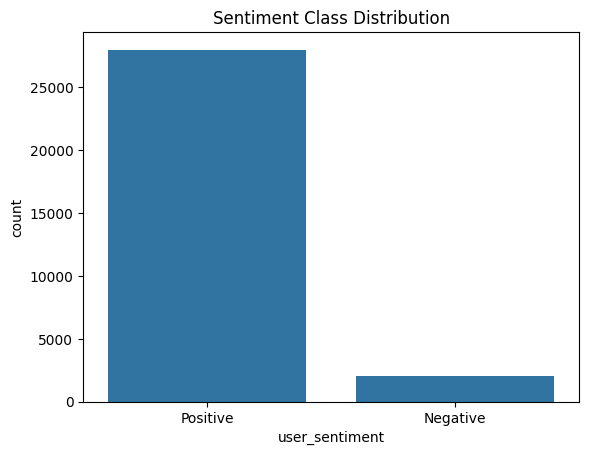

user_sentiment
Positive    93.25
Negative     6.75
Name: proportion, dtype: float64


In [202]:
# Check class distribution

sns.countplot(x=df_final['user_sentiment'])
plt.title("Sentiment Class Distribution")
plt.show()

# Print exact counts
print(df_final['user_sentiment'].value_counts(normalize=True) * 100)  # Percentage of each class

In [203]:
# Check class distribution before balancing
print("Class distribution in training set:\n", y_train.value_counts(normalize=True) * 100)
print("Class distribution in test set:\n", y_test.value_counts(normalize=True) * 100)

Class distribution in training set:
 user_sentiment
1    93.53
0     6.47
Name: proportion, dtype: float64
Class distribution in test set:
 user_sentiment
1    93.25
0     6.75
Name: proportion, dtype: float64


Model **Creation**

In [204]:
import logging
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(message)s")

class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        """
        Initialize ModelBuilder with the given model and dataset.
        """
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def train_model(self):
        """
        Train the model and return predicted classes on the test set.
        """
        self.model.fit(self.x_train, self.y_train)
        return self.model.predict(self.x_test)

    def evaluate_model(self, y_pred_class):
        """
        Evaluate model performance using various metrics and plots.
        """
        print("\n" + "=" * 50)
        print("MODEL EVALUATION STARTED")
        print("=" * 50 + "\n")

        results = self.evaluate_metrics(y_pred_class)

        print("\n" + "=" * 50)
        print("CLASSIFICATION REPORT")
        print("=" * 50 + "\n")
        self.display_classification_report(y_pred_class)

        print("\n" + "=" * 50)
        print("CONFUSION MATRIX")
        print("=" * 50 + "\n")
        self.plot_confusion_matrix(y_pred_class)

        print("\n" + "=" * 50)
        print("ROC CURVE")
        print("=" * 50 + "\n")
        self.plot_roc_curve()

        print("\n" + "=" * 50)
        print("MODEL EVALUATION COMPLETED")
        print("=" * 50 + "\n")

        return results

    def evaluate_metrics(self, y_pred_class):
        """
        Compute and display classification metrics.
        """
        results = {
            "Accuracy": metrics.accuracy_score(self.y_test, y_pred_class),
            "Precision": metrics.precision_score(self.y_test, y_pred_class),
            "Recall": metrics.recall_score(self.y_test, y_pred_class),
            "F1 Score": metrics.f1_score(self.y_test, y_pred_class),
        }

        # Check if the model supports probability predictions
        if hasattr(self.model, "predict_proba"):
            y_pred_prob = self.model.predict_proba(self.x_test)[:, 1]
            results["ROC-AUC Score"] = metrics.roc_auc_score(self.y_test, y_pred_prob)
        else:
            results["ROC-AUC Score"] = None  # Not supported

        # Print results with proper spacing
        print("\n" + "=" * 50)
        print("MODEL PERFORMANCE METRICS")
        print("=" * 50)
        for metric, value in results.items():
            if value is not None:
                print(f"{metric}: {value * 100:.2f}%")
        print("=" * 50 + "\n")

        return results

    def plot_confusion_matrix(self, y_pred_class):
        """
        Compute and visualize the confusion matrix.
        """
        cm = metrics.confusion_matrix(self.y_test, y_pred_class)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm / np.sum(cm), annot=True, cmap="Blues", fmt=".2%",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"]
        )
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

    def plot_roc_curve(self):
        """
        Plot the ROC curve using RocCurveDisplay.
        """
        if hasattr(self.model, "predict_proba"):
            RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)
            plt.title("ROC Curve")
            plt.show()
        else:
            print("\n[WARNING] ROC Curve cannot be plotted: Model does not support probability predictions.\n")

    def display_classification_report(self, y_pred_class):
        """
        Display the classification report with proper formatting.
        """
        report = metrics.classification_report(self.y_test, y_pred_class)
        print(report)  # Using print() instead of logging for better formatting

In [205]:
# checking distribution of clases in test set
print(y_test.value_counts())

user_sentiment
1    5595
0     405
Name: count, dtype: int64


1. Logistics Regression


MODEL EVALUATION STARTED


MODEL PERFORMANCE METRICS
Accuracy: 96.07%
Precision: 96.32%
Recall: 99.59%
F1 Score: 97.93%
ROC-AUC Score: 95.13%


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.89      0.47      0.62       405
           1       0.96      1.00      0.98      5595

    accuracy                           0.96      6000
   macro avg       0.93      0.73      0.80      6000
weighted avg       0.96      0.96      0.95      6000


CONFUSION MATRIX



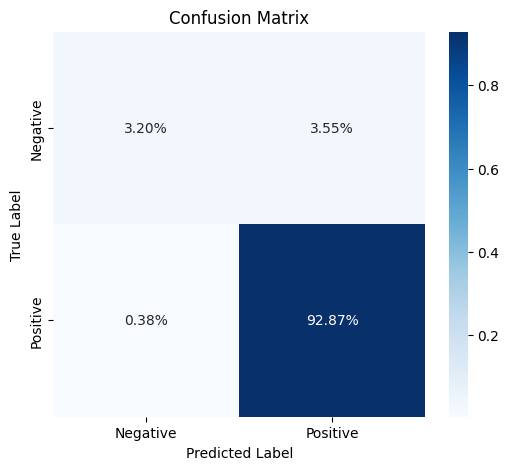


ROC CURVE



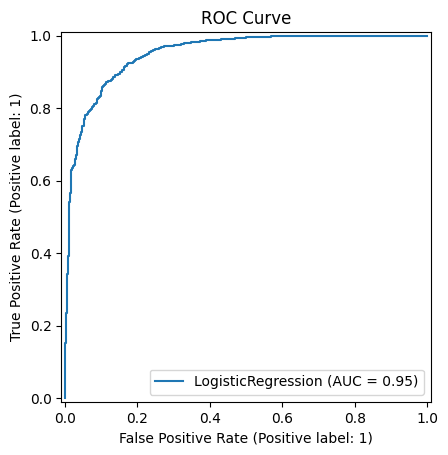


MODEL EVALUATION COMPLETED



In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
model_lr = LogisticRegression()

# Create ModelBuilder instance
builder_lr = ModelBuilder(model_lr, X_train_combined, X_test_combined, y_train, y_test)

# Train model
y_pred = builder_lr.train_model()

# Evaluate model
metrics_result_lr = builder_lr.evaluate_model(y_pred)

2. Naive Bayes


MODEL EVALUATION STARTED


MODEL PERFORMANCE METRICS
Accuracy: 95.52%
Precision: 95.96%
Recall: 99.37%
F1 Score: 97.64%
ROC-AUC Score: 93.13%


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.83      0.42      0.56       405
           1       0.96      0.99      0.98      5595

    accuracy                           0.96      6000
   macro avg       0.89      0.71      0.77      6000
weighted avg       0.95      0.96      0.95      6000


CONFUSION MATRIX



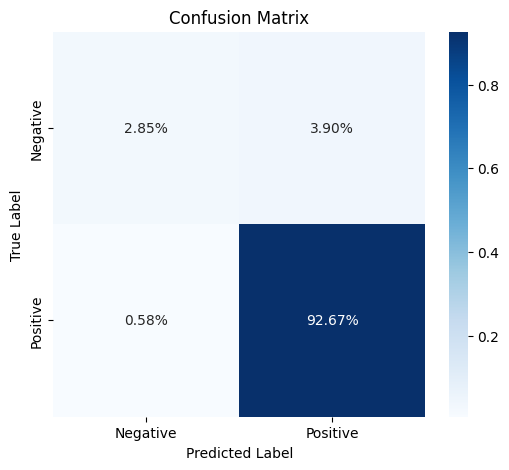


ROC CURVE



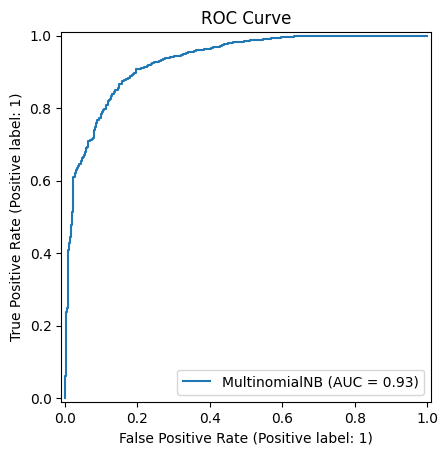


MODEL EVALUATION COMPLETED



In [207]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report



# Initialize model

model_nb = MultinomialNB(alpha=1.0)

# Create ModelBuilder instance
builder_nb = ModelBuilder(model_nb, X_train_combined, X_test_combined, y_train, y_test)

# Train model
y_pred = builder_nb.train_model()

# Evaluate model
metrics_result_nb = builder_nb.evaluate_model(y_pred)

3. Decision Tree


MODEL EVALUATION STARTED


MODEL PERFORMANCE METRICS
Accuracy: 95.17%
Precision: 95.63%
Recall: 99.36%
F1 Score: 97.46%
ROC-AUC Score: 82.16%


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.81      0.37      0.51       405
           1       0.96      0.99      0.97      5595

    accuracy                           0.95      6000
   macro avg       0.88      0.68      0.74      6000
weighted avg       0.95      0.95      0.94      6000


CONFUSION MATRIX



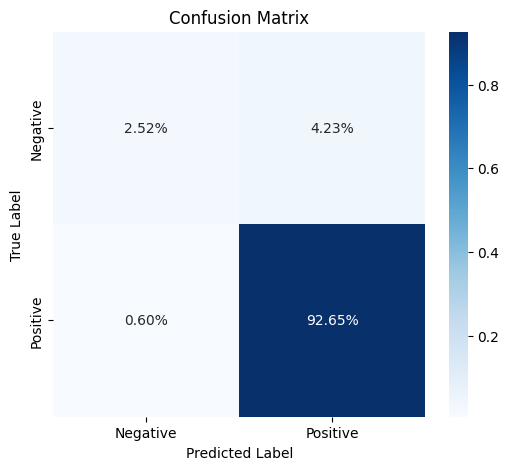


ROC CURVE



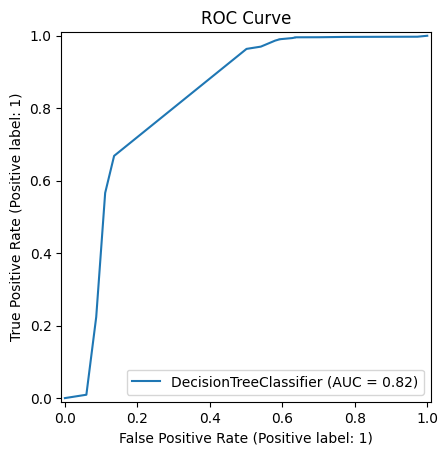


MODEL EVALUATION COMPLETED



In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model

model_dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

# Create ModelBuilder instance
builder_dt = ModelBuilder(model_dt, X_train_combined, X_test_combined, y_train, y_test)

# Train model
y_pred = builder_dt.train_model()

# Evaluate model
metrics_result_dt = builder_dt.evaluate_model(y_pred)

4. Random Forest


MODEL EVALUATION STARTED


MODEL PERFORMANCE METRICS
Accuracy: 95.73%
Precision: 95.86%
Recall: 99.73%
F1 Score: 97.76%
ROC-AUC Score: 92.03%


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.92      0.40      0.56       405
           1       0.96      1.00      0.98      5595

    accuracy                           0.96      6000
   macro avg       0.94      0.70      0.77      6000
weighted avg       0.96      0.96      0.95      6000


CONFUSION MATRIX



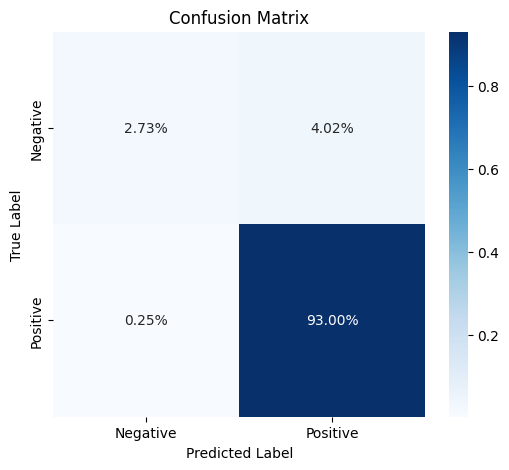


ROC CURVE



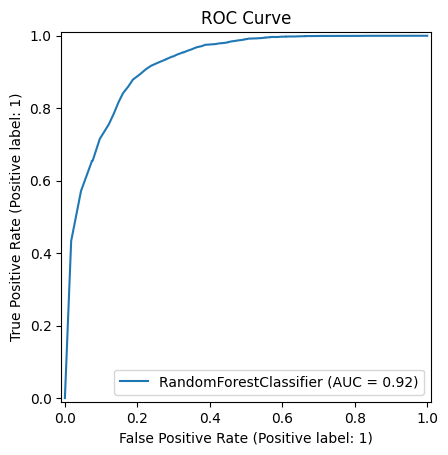


MODEL EVALUATION COMPLETED



In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create ModelBuilder instance
builder_rf = ModelBuilder(model_rf, X_train_combined, X_test_combined, y_train, y_test)

# Train model
y_pred = builder_rf.train_model()

# Evaluate model
metrics_result_rf = builder_rf.evaluate_model(y_pred)

5. XGBoost


MODEL EVALUATION STARTED


MODEL PERFORMANCE METRICS
Accuracy: 95.98%
Precision: 96.46%
Recall: 99.34%
F1 Score: 97.88%
ROC-AUC Score: 93.22%


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.84      0.50      0.63       405
           1       0.96      0.99      0.98      5595

    accuracy                           0.96      6000
   macro avg       0.90      0.74      0.80      6000
weighted avg       0.96      0.96      0.95      6000


CONFUSION MATRIX



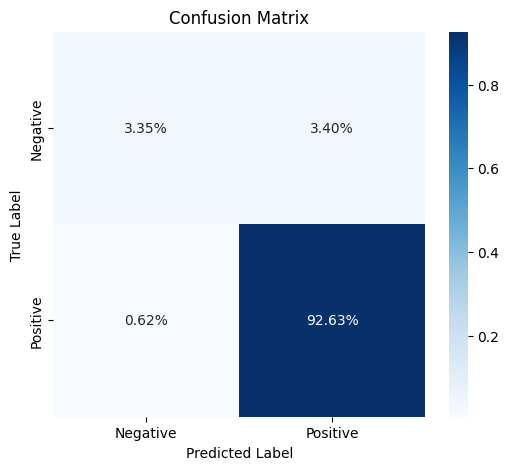


ROC CURVE



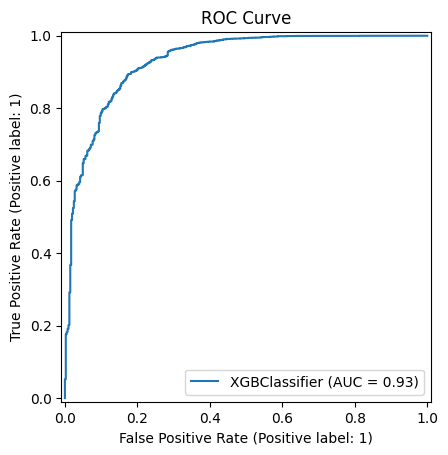


MODEL EVALUATION COMPLETED



In [210]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Create ModelBuilder instance
builder_xgb = ModelBuilder(model_xgb, X_train_combined, X_test_combined, y_train, y_test)

# Train model
y_pred = builder_xgb.train_model()

# Evaluate model
metrics_result_xgb = builder_xgb.evaluate_model(y_pred)

In [211]:
# Creating a table containing all model evaluation metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'],
    'Logistic Regression': pd.Series(metrics_result_lr),
    'Naïve Bayes': pd.Series(metrics_result_nb),
    'Decision Tree': pd.Series(metrics_result_dt),
    'Random Forest': pd.Series(metrics_result_rf),
    'XGBoost': pd.Series(metrics_result_xgb)
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Display the metrics table
df_metrics

,Metric,Logistic Regression,Naïve Bayes,Decision Tree,Random Forest,XGBoost
Accuracy,Accuracy,0.96,0.96,0.95,0.96,0.96
Precision,Precision,0.96,0.96,0.96,0.96,0.96
Recall,Recall,1.00,0.99,0.99,1.00,0.99
F1 Score,F1 Score,0.98,0.98,0.97,0.98,0.98
ROC-AUC Score,AUC Score,0.95,0.93,0.82,0.92,0.93


Comparing the above models on the metrics, XG Boost looks to be a better model, saving the XG Boost model as a pickle file for later use

Saving the model

In [212]:
import pickle
def save_object(obj, filename):
    filename = "pickle/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [213]:
save_object(model_xgb, 'sentiment-classification-xg-boost-model')

In [214]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [215]:
save_object(df_final, 'cleaned-data')

Recommendation System

Different Approaches to develop Recommendation System -

Here we are going to try with 2 of the Colloboarative filtering techniques: - User-User Based Approach - Item-Item Based Approach

In [216]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   30000 non-null  object
 1   brand                30000 non-null  object
 2   categories           30000 non-null  object
 3   manufacturer         29859 non-null  object
 4   name                 30000 non-null  object
 5   reviews_date         29954 non-null  object
 6   reviews_didPurchase  15932 non-null  object
 7   reviews_doRecommend  27430 non-null  object
 8   reviews_rating       30000 non-null  int64 
 9   reviews_text         30000 non-null  object
 10  reviews_title        29810 non-null  object
 11  reviews_username     29937 non-null  object
 12  user_sentiment       30000 non-null  object
 13  full_review          30000 non-null  object
dtypes: int64(1), object(13)
memory usage: 3.2+ MB


In [217]:
df_recommendation = df_reviews[["id", "name", "reviews_rating", "reviews_username"]]


In [218]:
#splitting the train and test
train_df, test_df = train_test_split(df_recommendation, test_size=0.25, random_state=42)

In [219]:
print(train_df.shape)
print(test_df.shape)

(22500, 4)
(7500, 4)


In [220]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [221]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train_df,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

Creating dummy train and test

In [222]:
# Copy the train dataset into dummy_train
dummy_train = train_df.copy()

In [223]:
dummy_train.head()

,id,name,reviews_rating,reviews_username
21177,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,bobdigi
23942,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4,skeeter
1247,AV1YneDPglJLPUi8IJyQ,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",5,mruduka
23622,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4,kiddro3523
28454,AVpftikC1cnluZ0-p31V,"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",1,newwmomma


In [224]:
# The products not rated by user is marked as 1 for prediction.
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [225]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

User similarity matrix

In [226]:
df_pivot.index.nunique()

19380

In [227]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [228]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]
(19380, 19380)


Prediction User-User

In [229]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [230]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.39045722, ..., 1.81848242, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ]])

In [231]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

Find 20 recommendation for the user

In [232]:
user_input = "08dallas"
print(user_input)

08dallas


In [233]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

,08dallas
id,
AVpfRTh1ilAPnD_xYic2,23.26
AVpfPaoqLJeJML435Xk9,22.26
AVpf0eb2LJeJML43EVSt,12.06
AVpf3VOfilAPnD_xjpun,7.56
AVpf2tw1ilAPnD_xjflC,7.20
AVpe41TqilAPnD_xQH3d,5.87
AVpfoSS51cnluZ0-oVH9,2.89
AVpfJP1C1cnluZ0-e3Xy,2.89
AVpfR5m0LJeJML436K3W,2.89


In [234]:
#display the top 20 product id, name and similarity_score
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train_df, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),23.26
873,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,22.26
3350,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),12.06
3989,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,7.56
10347,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),7.20
10864,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),5.87
11437,AVpfoSS51cnluZ0-oVH9,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,2.89
11486,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,2.89
13034,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,2.89
13185,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,2.87


Evaluation User-User

In [235]:
# Find out the common users of test and train dataset.
common = test_df[test_df.reviews_username.isin(train_df.reviews_username)]
common.shape

(1776, 4)

In [236]:
# Find out the common users of test and train dataset.
common = test_df[test_df.reviews_username.isin(train_df.reviews_username)]
common.shape

(1776, 4)

In [237]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [238]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,19280,19281,19282,19283,19284,19285,19286,19287,19288,19289,19290,19291,19292,19293,19294,19295,19296,19297,19298,19299,19300,19301,19302,19303,19304,19305,19306,19307,19308,19309,19310,19311,19312,19313,19314,19315,19316,19317,19318,19319,19320,19321,19322,19323,19324,19325,19326,19327,19328,19329,19330,19331,19332,19333,19334,19335,19336,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375,19376,19377,19378,19379
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.00,0.

In [239]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,19280,19281,19282,19283,19284,19285,19286,19287,19288,19289,19290,19291,19292,19293,19294,19295,19296,19297,19298,19299,19300,19301,19302,19303,19304,19305,19306,19307,19308,19309,19310,19311,19312,19313,19314,19315,19316,19317,19318,19319,19320,19321,19322,19323,19324,19325,19326,19327,19328,19329,19330,19331,19332,19333,19334,19335,19336,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375,19376,19377,19378,19379
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
01impala,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0

In [240]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [241]:
user_correlation_df_1.shape

(1518, 19380)

In [242]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [243]:
user_correlation_df_3 = user_correlation_df_2.T

In [244]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  1.85485666,  0.        , ...,  1.85485666,
         2.29174624,  1.        ],
       [ 3.10190162, 10.91070777,  0.        , ...,  1.18042355,
         0.        ,  3.53553391],
       [ 0.        ,  3.12347524,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5       ,  4.92031173,  0.        , ...,  0.        ,
         0.        ,  5.        ],
       [ 0.        ,  3.12347524,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.33205081,  6.3058555 ,  0.        , ...,  1.0016226 ,
         0.        ,  0.        ]])

In [245]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [246]:
dummy_test.shape

(1518, 119)

In [247]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [248]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [249]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [250]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [251]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [252]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [253]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [254]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.161605143981965


Item Based Recommendation

In [255]:
df_pivot = pd.pivot_table(train_df,
    index=product_column,
    columns=user_column,
    values=value_column
)

In [256]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [257]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234561,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,1421nikki,143st,1515,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gamer,1glenn,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2827,28green,295259,2athome,2bgreen,2big,2busy4u,2choclabs,2clean4me,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2rogersmakearight,2shoes,...,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zeek,zeek09,zegan,zenanuts,zenmon,zeramm,zero,zetamom,zfem2,zhjwpp,zhynellebb,zibby4,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [258]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [259]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Prediction - item-item

In [260]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00051462, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00102925, 0.        ,
        0.        ]])

Filtering the rating only for the products not rated by the user for recommendation

In [261]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

Finding the top 20 recommendation for the user

In [262]:
# Take the user ID as input
user_input = '08dallas'
print(user_input)

08dallas


In [263]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

,08dallas
id,
AVpe8xjUilAPnD_xRkxC,4.93e-02
AVpf7I3i1cnluZ0-tnL6,4.68e-02
AVpe41TqilAPnD_xQH3d,4.38e-02
AVpf0eb2LJeJML43EVSt,2.37e-02
AVpf2tw1ilAPnD_xjflC,2.27e-02
AVpf385g1cnluZ0-s0_t,1.47e-02
AVpfoSS51cnluZ0-oVH9,1.43e-02
AVpfR5m0LJeJML436K3W,1.05e-02
AVpfJP1C1cnluZ0-e3Xy,2.40e-03


In [264]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train_df, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpe8xjUilAPnD_xRkxC,The Honest Company Laundry Detergent,4.93e-02
12,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,4.68e-02
35,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.38e-02
608,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),2.37e-02
1247,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),2.27e-02
1764,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",1.47e-02
1911,AVpfoSS51cnluZ0-oVH9,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,1.43e-02
1960,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,1.05e-02
2111,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,2.40e-03
3659,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,1.65e-03


##Evaluation - item-it

In [265]:
# Re-run the train_test_split cell first to ensure 'test' is a DataFrame.
train_df, test_df = train_test_split(df_recommendation, test_size=0.25, random_state=42)

# Now, the 'test' variable should be correctly initialized as a DataFrame.
common = test_df[test_df.id.isin(train_df.id)]
common.shape

(7487, 4)

In [266]:
common.head(4)

,id,name,reviews_rating,reviews_username
2308,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),5,iplsports
22404,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,1,crysv
23397,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4,sammhc12
25058,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,spyder


In [267]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [268]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [269]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,8.39e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.97e-03,0.0,0.0,0.0,0.0,2.80e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.95e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.61

In [270]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
df_subtracted

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234561,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,1421nikki,143st,1515,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gamer,1glenn,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2827,28green,295259,2athome,2bgreen,2big,2busy4u,2choclabs,2clean4me,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2rogersmakearight,2shoes,...,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zeek,zeek09,zegan,zenanuts,zenmon,zeramm,zero,zetamom,zfem2,zhjwpp,zhynellebb,zibby4,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [271]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.28655752e-03, 1.28655752e-03, 1.28655752e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [272]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)



In [273]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [274]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5699746380356063


In [275]:
# saving the correlation matrix of user based recommender
save_object(user_final_rating, "user_final_rating")

Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in model.py

In [276]:
#def get_sentiment_recommendations(user):
#  if (user in user_final_rating.index):
    # get the product recommedation using the trained ML model

    # Get top 20 recommended products from the best recommendation model
#    top20_recommended_products = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)

    # Get only the recommended products from the prepared dataframe "df_final" and their non-redundant clean reviews text
#    df_final = pickle.load(open('./pickle/cleaned-data.pkl','rb'))
#    df_top20_products = df_final[df_final.name.isin(top20_recommended_products)].drop_duplicates(subset=['cleaned_review'])

    # Ppass them through TF-IDF vectorizer to convert the data into suitable format for modeling predictions
#    tfidf = pickle.load(open('./pickle/tfidf-vectorizer.pkl','rb'))
#    X = tfidf.transform(df_top20_products['cleaned_review'])

    # Create a DataFrame from the TF-IDF transformed data with the correct feature names
#    X_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

    # Ensure numerical features are from df_top20_products, not df_final since our xgbm needs num and text features both
    # X_num = df_top20_products[['review_length', 'word_count', 'vader_sentiment', 'normalized_rating']]
#    X_num = df_top20_products[['review_length']]

    # Reset indices before concatenation
#    X_df = X_df.reset_index(drop=True)
#    X_num = X_num.reset_index(drop=True)

    # Concatenate the TF-IDF and numerical features with the training features order first
#    df_top_20_products_final_features = pd.concat([X_df, X_num], axis=1)

    # Use the best sentiment model to predict the sentiment for these user reviews
#    xgb = pickle.load(open('./pickle/sentiment-classification-xg-boost-model.pkl','rb'))
    # Predict on the DataFrame used for feature engineering, ensuring matching indices
#    df_top20_products['predicted_sentiment'] = xgb.predict(df_top_20_products_final_features)

    # Create a new column to map Positive sentiment to 1 and Negative sentiment to 0. This will allow us to easily summarize the data
#    df_top20_products['positive_sentiment'] = df_top20_products['predicted_sentiment'].apply(lambda x: 1 if x==1 else 0)

    # Create a new dataframe "pred_df" to store the count of positive user sentiments
#    pred_df = df_top20_products.groupby(by='name').sum()
#    pred_df = pred_df.rename(columns={'positive_sentiment': 'pos_sent_count'})

    # Create a column to measure the total sentiment count
#    pred_df['total_sent_count'] = df_top20_products.groupby(by='name')['predicted_sentiment'].count()

    # Create a column that measures the % of positive user sentiment for each product review
#    pred_df['pos_sent_percentage'] = np.round(pred_df['pos_sent_count']/pred_df['total_sent_count']*100,2)

    # Reset index to make 'name' a column instead of the index
#    pred_df = pred_df.reset_index()

    # Return top 5 recommended products to the user
#    result = pred_df.sort_values(by='pos_sent_percentage', ascending=False)[:5][['name', 'pos_sent_percentage']]
#    return result

In [278]:
import pandas as pd
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
import numpy as np # Ensure numpy is imported for np.round
import pickle

# Assuming `X_train`, `df_final` are available from the global scope.

def get_sentiment_recommendations(user):
    # Load vectorizer and model from pickle files inside the function to ensure they are always available
    # regardless of global scope state or kernel restarts.
    tfidf_vectorizer = pickle.load(open('./pickle/tfidf-vectorizer.pkl','rb'))
    model_xgb = pickle.load(open('./pickle/sentiment-classification-xg-boost-model.pkl','rb'))

    if (user in user_final_rating.index):
        # Get top 20 recommended product IDs from the best recommendation model
        top20_recommended_product_ids = user_final_rating.loc[user].sort_values(ascending=False)[0:20].index.tolist()

        # Get relevant product details from df_final for these recommended products
        df_top20_products = df_final[df_final['id'].isin(top20_recommended_product_ids)].drop_duplicates(subset=['id', 'cleaned_review']).copy() # Use .copy() to avoid SettingWithCopyWarning

        if df_top20_products.empty:
            print(f"No product details found for recommended IDs for user {user}.")
            return pd.DataFrame() # Return empty DataFrame if no products found

        # Ensure review_length is present and up-to-date for the current subset of products
        df_top20_products['review_length'] = df_top20_products['cleaned_review'].apply(len)

        # Transform text features
        X_tfidf = tfidf_vectorizer.transform(df_top20_products['cleaned_review'].values.astype(str))

        # Scale numeric feature (review_length)
        local_review_length_scaler = MinMaxScaler()
        # Fit on original X_train review_length, then transform current subset
        # Ensure X_train is available from the global scope or loaded.
        local_review_length_scaler.fit(X_train[['review_length']])
        X_num = local_review_length_scaler.transform(df_top20_products[['review_length']])

        # Combine features
        X_combined = hstack((X_tfidf, X_num))

        # Print shapes for debugging and verification
        print(f"Shape of X_tfidf for recommendations: {X_tfidf.shape}")
        # Use get_feature_names_out() to accurately show the number of features the vectorizer was fitted with
        print(f"Number of features in TF-IDF vocabulary: {len(tfidf_vectorizer.get_feature_names_out())}")
        print(f"Shape of X_num for recommendations: {X_num.shape}")
        print(f"Shape of X_combined before prediction: {X_combined.shape}")
        expected_features = model_xgb.n_features_in_ if hasattr(model_xgb, 'n_features_in_') else 'unknown'
        print(f"Model expects {expected_features} features.")

        # Predict sentiment
        df_top20_products['predicted_sentiment'] = model_xgb.predict(X_combined)

        # Calculate total reviews and positive reviews per product name in one go
        sentiment_summary_df = df_top20_products.groupby('name').agg(
            total_review_count=('predicted_sentiment', 'size'),
            pos_review_count=('predicted_sentiment', lambda x: (x == 1).sum())
        ).reset_index()

        # Calculate positive sentiment percentage
        sentiment_summary_df['pos_sentiment_percentage'] = np.round(
            (sentiment_summary_df['pos_review_count'] / sentiment_summary_df['total_review_count']) * 100, 2
        )

        # Ensure 'pos_sentiment_percentage' is numeric before sorting to avoid TypeError
        sentiment_summary_df['pos_sentiment_percentage'] = pd.to_numeric(sentiment_summary_df['pos_sentiment_percentage'], errors='coerce').fillna(0)

        # Return top 5 recommended products sorted by positive sentiment percentage
        result = sentiment_summary_df.sort_values(by='pos_sentiment_percentage', ascending=False)[:5][['name', 'pos_sentiment_percentage']]
        return result
    else:
        print(f"User name {user} doesn't exist")
        return pd.DataFrame() # Return empty DataFrame for non-existent user

#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("08dallas")

Shape of X_tfidf for recommendations: (18497, 337)
Number of features in TF-IDF vocabulary: 337
Shape of X_num for recommendations: (18497, 1)
Shape of X_combined before prediction: (18497, 338)
Model expects 338 features.


,name,pos_sentiment_percentage
0,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",100.0
1,CeraVe SA Renewing Cream,100.0
2,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,100.0
9,Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer,100.0
8,Jason Aldean - They Don't Know,100.0


In [279]:
#get the top 5
get_sentiment_recommendations("08dallas")[:5]

Shape of X_tfidf for recommendations: (18497, 337)
Number of features in TF-IDF vocabulary: 337
Shape of X_num for recommendations: (18497, 1)
Shape of X_combined before prediction: (18497, 338)
Model expects 338 features.


,name,pos_sentiment_percentage
0,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",100.0
1,CeraVe SA Renewing Cream,100.0
2,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,100.0
9,Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer,100.0
8,Jason Aldean - They Don't Know,100.0


In [280]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("test123")

User name test123 doesn't exist


""


In [281]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will recommend"])
y_pred_sample = model_xgb.predict(X_sample)
y_pred_sample

ValueError: Feature shape mismatch, expected: 338, got 337

In [ ]:
X_sample = tfidf_vectorizer.transform(["worst product, quality is poor"])
y_pred_sample = model_xgb.predict(X_sample)
y_pred_sample